In [1]:
import numpy as np
import pandas as pd
from river import optim
from river import metrics
from river.drift import ADWIN, EDDM
from sail.models.auto_ml.tune import SAILTuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.drift_detection.drift_detector import SAILDriftDetector
from sail.transfomers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../../datasets/agrawal.csv").head(50000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(steps=steps, scoring=metrics.Accuracy)

#### HPO Params


In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
]

# params_grid = {
#     "classifier__l2": [0.1, 0.9],
#     "classifier__intercept_init": [0.2, 0.5],
# }


#### Create Model Instance


In [6]:
auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_method=SAILTuneGridSearchCV,
    search_method_params={
        "num_cpus_per_trial": 1,
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
        "keep_best_configurations": 2
    },
    search_data_size=1000,
    incremental_training=True,
    drift_detector=SAILDriftDetector(model=EDDM(), drift_param="difference"),
    pipeline_strategy="DetectAndIncrement",
)

[2023-07-11 01:05:06:383] - INFO - SAIL : Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training


In [7]:
y_preds = []
y_true = []
batch_size = 50

for start in range(0, 1500, batch_size):

    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = auto_pipeline.predict(X_train)
        if preds is not None:
            y_preds.extend(list(preds))
            y_true.extend(list(y_train))

    auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])


2023-07-11 01:05:19,874	INFO tune.py:945 -- Total run time: 8.94 seconds (8.92 seconds for the tuning loop).
[2023-07-11 01:05:22:363] - INFO - SAIL : Pipeline tuning completed. Disconnecting Ray cluster...
[2023-07-11 01:05:22:364] - INFO - SAIL : Found best params: {'Imputer': 'passthrough', 'classifier': AdaptiveRandomForestClassifier(), 'classifier__n_models': 10}


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0021s, Metric=Accuracy, Batch Size=50, P_Score=0.96]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.065s, Batch Size=50, P_Score=0.96]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.98]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.045s, Batch Size=50, P_Score=0.98]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.94]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0009s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.045s, Batch Size=50, P_Score=0.94]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.935]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0007s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.043s, Batch Size=50, P_Score=0.935]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.924]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.053s, Batch Size=50, P_Score=0.924]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.923]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.066s, Batch Size=50, P_Score=0.923]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0021s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.054s, Batch Size=50, P_Score=0.929]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0019s, Metric=Accuracy, Batch Size=50, P_Score=0.932]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.046s, Batch Size=50, P_Score=0.932]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0011s, Metric=Accuracy, Batch Size=50, P_Score=0.922]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0008s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.051s, Batch Size=50, P_Score=0.922]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0008s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.92]             


#### Save model


In [8]:
auto_pipeline.save_model(".")

[2023-07-11 01:05:23:236] - INFO - SAIL (SAILAutoPipeline) : making directory tree ./sail_auto_pipeline
[2023-07-11 01:05:23:237] - INFO - SAIL : making directory tree ./sail_auto_pipeline/sail_pipeline


'./sail_auto_pipeline'

#### Load model


In [9]:
new_auto_pipeline = SAILAutoPipeline.load_model(".")

[2023-07-11 01:05:25:969] - INFO - SAIL : Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Continue training using the load model

In [10]:
for start in range(1501, 3001, batch_size):

    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = new_auto_pipeline.predict(X_train)
        if preds is not None:
            y_preds.extend(list(preds))
            y_true.extend(list(y_train))

    new_auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.922]
SAIL Drift detection:  36%===        [Points: 18/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=Yes]
[2023-07-11 01:05:26:193] - INFO - SAIL : Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-07-11 01:05:26:194] - WARNING - SAIL (SAILAutoPipeline) : The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.


>>>--------------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [ETA: 00:00<00:00, Elapsed:0.058s, Model=AdaptiveRandomForestClassifier, Batch Size=50, P_Score=0.92]


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0023s, Metric=Accuracy, Batch Size=50, P_Score=0.92]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.050s, Batch Size=50, P_Score=0.92]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.922]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.054s, Batch Size=50, P_Score=0.922]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.925]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0008s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.050s, Batch Size=50, P_Score=0.925]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.923]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0014s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.049s, Batch Size=50, P_Score=0.923]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.921]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.053s, Batch Size=50, P_Score=0.921]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0021s, Metric=Accuracy, Batch Size=50, P_Score=0.924]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0019s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.061s, Batch Size=50, P_Score=0.924]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0029s, Metric=Accuracy, Batch Size=50, P_Score=0.925]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0020s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.057s, Batch Size=50, P_Score=0.925]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.927]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.049s, Batch Size=50, P_Score=0.927]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0021s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0015s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.056s, Batch Size=50, P_Score=0.926]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0024s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.059s, Batch Size=50, P_Score=0.929]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.93]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.056s, Batch Size=50, P_Score=0.93]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.927]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.053s, Batch Size=50, P_Score=0.927]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.929]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0008s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.049s, Batch Size=50, P_Score=0.929]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.927]
SAIL Drift detection:   2%           [Points: 1/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=Yes]
[2023-07-11 01:05:27:476] - INFO - SAIL : Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-07-11 01:05:27:476] - WARNING - SAIL (SAILAutoPipeline) : The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.


>>>--------------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [ETA: 00:00<00:00, Elapsed:0.054s, Model=AdaptiveRandomForestClassifier, Batch Size=50, P_Score=0.929]


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0174s, Metric=Accuracy, Batch Size=50, P_Score=0.928]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.928]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0018s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0012s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.926]             

>>>--------------------------------------------------------------------------------------------



SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.051s, Batch Size=50, P_Score=0.926]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.928]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.928]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0022s, Metric=Accuracy, Batch Size=50, P_Score=0.925]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0011s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.076s, Batch Size=50, P_Score=0.925]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0020s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0008s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.048s, Batch Size=50, P_Score=0.926]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.928]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.047s, Batch Size=50, P_Score=0.928]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0010s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.049s, Batch Size=50, P_Score=0.926]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0016s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0031s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.045s, Batch Size=50, P_Score=0.926]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0013s, Metric=Accuracy, Batch Size=50, P_Score=0.927]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0013s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.059s, Batch Size=50, P_Score=0.927]             


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0012s, Metric=Accuracy, Batch Size=50, P_Score=0.927]
SAIL Drift detection:  56%=====      [Points: 28/50, Elapsed:0.0014s, Detector=EDDM, Batch Size=50, Param=differene, Drift=Yes]
[2023-07-11 01:05:28:497] - INFO - SAIL : Drift Detected in the data. Final Estimator will be incrementally trained on the next train()
[2023-07-11 01:05:28:497] - WARNING - SAIL (SAILAutoPipeline) : The current best pipeline is STALE. Pipeline becomes stale when data drift occurs. You can call 'train' with fresh data to get the best pipeline.


>>>--------------------------------------------------------------------------------------------


SAIL Model Partial fit: 100%========== [ETA: 00:00<00:00, Elapsed:0.053s, Model=AdaptiveRandomForestClassifier, Batch Size=50, P_Score=0.927]


>>>--------------------------------------------------------------------------------------------


SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0014s, Metric=Accuracy, Batch Size=50, P_Score=0.926]
SAIL Drift detection: 100%========== [Points: 50/50, Elapsed:0.0015s, Detector=EDDM, Batch Size=50, Param=differene, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.048s, Batch Size=50, P_Score=0.926]             


#### Classification Report


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1324
           1       0.94      0.84      0.89       676

    accuracy                           0.93      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       0.93      0.93      0.93      2000



#### Plot confusion matrix


<Axes: >

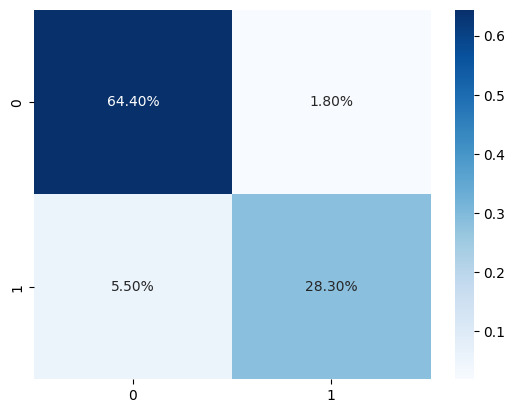

In [12]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')